In [270]:
from collections import OrderedDict
from datetime import timedelta
from functools import partial
import re

import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
from wmfdata import hive, mariadb, charting
from wmfdata.utils import pct_str

In [271]:
charting.set_mpl_style()

In [272]:
null_prop = lambda s: len(s[s.isnull()]) / len(s)
pos_prop = lambda s: len(s[s > 0]) / len(s)

# Data wrangling

## Loading

In [273]:
may_events = pd.read_csv("data/may_events.tsv", sep="\t")

In [274]:
sessions_dtypes = {
    "wiki": "category",
    "page_namspace": int,
    "init_count": int,
    "loaded_count": int,
    "ready_count": int,
    "save_intent_count": int,
    "save_attempt_count": int,
    "save_success_count": int,
    "save_failure_count": int,
    "abort_count": int,
    "actions": str,
    "edit_count": int,
    "editor": "category",
    "platform": "category",
}

may_sessions_r = pd.read_csv(
    "data/may_sessions.tsv", 
    sep="\t", 
    dtype=sessions_dtypes,
)

In [275]:
%%time
may_sessions_r["min_timestamp"] = pd.to_datetime(may_sessions_r["min_timestamp"], format="%Y%m%d%H%M%S")
may_sessions_r["max_timestamp"] = pd.to_datetime(may_sessions_r["max_timestamp"], format="%Y%m%d%H%M%S")

CPU times: user 47.4 s, sys: 164 ms, total: 47.6 s
Wall time: 47.4 s


## Analysis copy

In [276]:
may_sessions = may_sessions_r.copy()

## Platforms and editors

The "desktop" platform is frequently recorded incorrectly as "other".

In [277]:
may_sessions["platform"].value_counts()

desktop          3381655
phone            1932821
other-desktop     311244
other              16927
desktop-other       2051
Name: platform, dtype: int64

Let's overwrite that.

In [278]:
may_sessions["platform"] = may_sessions["platform"].replace(
    to_replace=["desktop-other", "other", "other-desktop"],
    value="desktop"
).cat.remove_unused_categories()

We also have a lot of editors. The data is correct, but we're not interested in most.

In [279]:
pd.pivot_table(
    may_sessions,
    values="actions",
    index="editor",
    columns="platform",
    aggfunc=len,
    fill_value=0
)

platform,desktop,phone
editor,,
visualeditor,331421,13042
visualeditor-wikitext,0,1179
visualeditor-wikitext-2017,354,0
wikitext,3367759,1910999
wikitext-2017,11917,0
wikitext-2017-visualeditor,426,0
wikitext-visualeditor,0,7601


The 2017 wikitext editor is a desktop-only opt-in beta feature, and is not widely used. We can remove the sessions that involved it.

In [280]:
nwe_indexes = may_sessions[may_sessions["editor"].str.contains("wikitext-2017")].index
may_sessions.drop(nwe_indexes, inplace=True)

The phone sessions that mix the visual and wikitext editors are more important, because mobile VE is the focus on this project and we don't want to throw away any data about it. You can't switch between the two mobile editors once you make any changes, so we can treat the last editor in the session as the true editor.

In [281]:
may_sessions["editor"] = may_sessions["editor"].replace(
    to_replace={
        "visualeditor-wikitext": "wikitext",
        "wikitext-visualeditor": "visualeditor"
    }
)

may_sessions["editor"] = pd.Categorical(may_sessions["editor"])

Things look a lot simpler now!

In [282]:
pd.pivot_table(
    may_sessions,
    values="actions",
    index="editor",
    columns="platform",
    aggfunc=len,
    fill_value=0
)

platform,desktop,phone
editor,,
visualeditor,331421,20643
wikitext,3367759,1912178


## Session duration

In [283]:
may_sessions["duration"] = may_sessions["max_timestamp"] - may_sessions["min_timestamp"]

## Bin based on experience

In [284]:
ec_bins = [0, 1, 10, 100, 1000, np.inf]
ec_labels = ["0 edits (new editor)", "1-9 edits", "10-99 edits", "100-999 edits", "1000+ edits"]

def bin_experience_with_IP(df):
    # Bin based on edits
    binned = pd.cut(df["edit_count"], bins=ec_bins, right=False, labels=ec_labels)

    # Create ordered categories including IP
    new_cats = binned.cat.categories.copy().tolist()
    new_cats.insert(0, "IP")

    # Override edit bin if the class is IP
    ips = may_sessions[may_sessions["user_class"] == "IP"]["user_class"]
    
    # Combine into a categorical
    combined = ips.combine_first(binned)
    return pd.Categorical(combined, categories=new_cats, ordered=True)

In [285]:
may_sessions["experience"] = bin_experience(may_sessions)

# Mobile edit proportion

In [299]:
editors_r = hive.run("""
select
    coalesce(event_user_text, event_user_text_historical) as user_name,
    not event_user_is_anonymous as registered,
    count(*) as yearly_edits,
    sum(cast(
        coalesce(mve.editor, "desktop wikitext editor") in ("mobile visual editor", "mobile wikitext editor")
    as int)) / count(*) as mobile_edit_proportion
from wmf.mediawiki_history mh
left join neilpquinn.mob_or_ve_edits mve
on 
    mve.wiki = mh.wiki_db and
    mve.rev_id = mh.revision_id
where
    mh.event_timestamp >= "2017-10" and
    event_entity = "revision" and
    event_type = "create" and
    snapshot = "2018-09"
group by coalesce(event_user_text, event_user_text_historical), event_user_is_anonymous
""")

In [302]:
editors = editors_r.copy()
editors.head()

,user_name,registered,yearly_edits,mobile_edit_proportion
0,! Bikkit !,True,583,0.0
1,!Alla17,True,45,0.0
2,!Ann07,True,1,0.0
3,!Maciek!Wawa,True,2,0.0
4,!Puce456,True,1,1.0


In [303]:
def bin_platform(x):
    if x == 0:
        return "desktop only"
    elif x == 1:
        return "mobile only"
    else:
        return "mixed"
    
editors["platform"] = pd.Categorical(editors["mobile_edit_proportion"].apply(bin_platform))

editors["activity_level"] = pd.cut(
    editors["yearly_edits"], 
    bins=ec_bins[1:], 
    labels=ec_labels[1:],
    right=False
)

In [304]:
reg_editors = editors.query("registered == True")
ip_editors = editors.query("registered == False")

In [305]:
platform_prop = reg_editors.groupby("platform")["user_name"].agg(len) / len(reg_editors)
pd.DataFrame(platform_prop).applymap(pct_str).T

platform,desktop only,mixed,mobile only
user_name,74.9%,6.2%,18.9%


In [306]:
by_act = reg_editors.groupby(["activity_level", "platform"])["user_name"].agg(len).unstack()
by_act.apply(lambda row: row / row.sum(), axis=1).applymap(pct_str)

platform,desktop only,mixed,mobile only
activity_level,,,
1-9 edits,74.5%,3.4%,22.1%
10-99 edits,78.5%,15.5%,6.0%
100-999 edits,69.6%,28.6%,1.9%
1000+ edits,66.7%,33.1%,0.1%


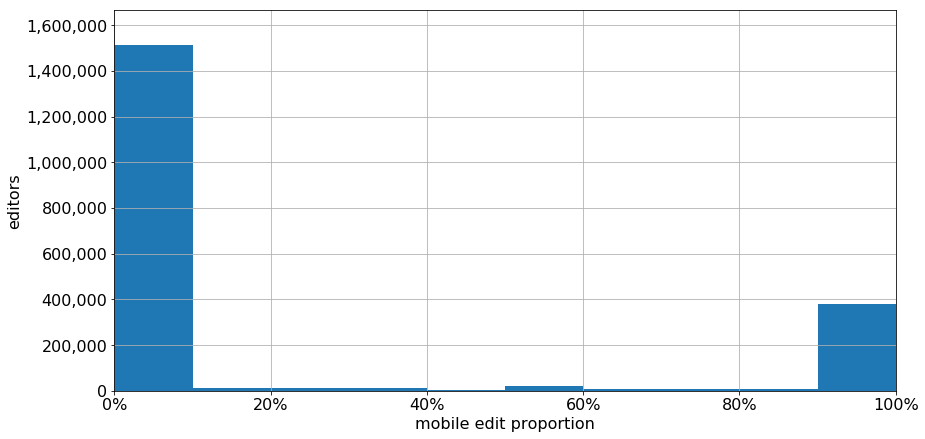

In [323]:
fig, ax = plt.subplots()
ax.hist(reg_editors["mobile_edit_proportion"])
ax.margins(y=0.1, tight=True)
ax.yaxis.set_major_formatter(charting.comma_fmt)
ax.xaxis.set_major_formatter(charting.pct_fmt)
ax.set_ylabel("editors")
ax.set_xlabel("mobile edit proportion");

# Interface retention

In [ ]:
# For all the people who edited Oct 2017–March 2018, find their first edit with each interface 
# and join it to all their edits from Oct 2017-Sep 2018 with the same interface

edits_r = hive.run("""
with first_edits as (
    select
        event_user_text,
        coalesce(editor, "desktop wikitext editor") as editor,
        min(event_timestamp) as first_edit_time,
        min(event_user_revision_count) as initial_edit_count
    from wmf.mediawiki_history mh
    left join neilpquinn.mob_or_ve_edits mve
    on 
        mve.wiki = mh.wiki_db and
        mve.rev_id = mh.revision_id
    where
        event_timestamp >= "2017-10" and
        event_timestamp < "2018-04" and
        not event_user_is_anonymous and
        event_entity = "revision" and
        event_type = "create" and
        mh.snapshot = "2018-09"
    group by event_user_text, editor
)
select
user_name,
interface,
week_number,
min(initial_edit_count) as initial_edit_count,
count(*) as edits
from (
    select
        fe.event_user_text as user_name,
        fe.editor as interface,
        fe.initial_edit_count as initial_edit_count,
        event_timestamp,
        (fe.first_edit_time = mh.event_timestamp) as first_edit,
        -- If datediff is 0-7, week 1; if 8-14, week 2; etc.
        if(
            ceil(datediff(event_timestamp, first_edit_time) / 7) != 0,
            ceil(datediff(event_timestamp, first_edit_time) / 7),
            1
        ) as week_number
    from first_edits fe
    left join wmf.mediawiki_history mh on
        fe.event_user_text = mh.event_user_text and
        mh.snapshot = "2018-09"
    left join neilpquinn.mob_or_ve_edits mve on 
        mve.wiki = mh.wiki_db and
        mve.rev_id = mh.revision_id
    where
        fe.editor = coalesce(mve.editor, "desktop wikitext editor") and
        -- Limit to events with 182 days (26 full weeks) after starting to avoid censoring
        datediff(event_timestamp, first_edit_time) <= 182 and
        event_timestamp >= "2017-10" and
        event_timestamp < "2018-10" and
        event_entity = "revision" and
        event_type = "create"
) edits
group by user_name, interface, week_number
""")

In [226]:
weekly_edits = edits_r.drop(["initial_edit_count"], axis=1)
weekly_edits.head()

,user_name,interface,week_number,edits
0,! Bikkit !,desktop wikitext editor,14,24
1,! Bikkit !,desktop wikitext editor,26,6
2,!!Ethereal!!,desktop wikitext editor,2,1
3,!!Priyanshu Patel!!,desktop wikitext editor,1,2
4,!0Clarke,desktop wikitext editor,1,4


In [227]:
weekly_edits = weekly_edits.set_index(["user_name", "interface", "week_number"]).unstack()
weekly_edits = weekly_edits.fillna(0).apply(np.uint32)
weekly_edits.columns = weekly_edits.columns.droplevel(0)
weekly_edits.columns.name = None
weekly_edits = weekly_edits.rename(columns = lambda x: "week {!s}".format(x))
weekly_edits.head()

,,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,...,week 17,week 18,week 19,week 20,week 21,week 22,week 23,week 24,week 25,week 26
user_name,interface,,,,,,,,,,,,,,,,,,,,,
! Bikkit !,desktop wikitext editor,4,0,15,0,2,14,31,6,0,0,...,9,0,0,0,0,46,47,16,0,6
!! !!ПОМОГИТЕ СЕСТРЕ НА ОПЕРАЦИЮ!! !!,desktop wikitext editor,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!!7597JOBV++!,desktop wikitext editor,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!!Ethereal!!,desktop wikitext editor,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!!Priyanshu Patel!!,desktop wikitext editor,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
weekly_retention = weekly_edits.groupby("interface").agg(pos_prop)
weekly_retention.applymap(pct_str)

,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,...,week 17,week 18,week 19,week 20,week 21,week 22,week 23,week 24,week 25,week 26
interface,,,,,,,,,,,,,,,,,,,,,
desktop visual editor,100.0%,8.6%,7.0%,6.1%,5.5%,5.1%,4.7%,4.4%,4.1%,3.9%,...,3.1%,3.0%,3.0%,2.9%,2.8%,2.8%,2.7%,2.7%,2.7%,2.7%
desktop wikitext editor,100.0%,12.4%,10.6%,9.7%,9.2%,8.7%,8.3%,8.0%,7.8%,7.5%,...,6.8%,6.8%,6.7%,6.6%,6.6%,6.5%,6.5%,6.4%,6.3%,6.3%
mobile visual editor,100.0%,4.4%,3.4%,3.0%,2.6%,2.3%,2.1%,2.0%,1.9%,1.8%,...,1.3%,1.3%,1.3%,1.1%,1.0%,1.1%,1.1%,1.1%,1.1%,1.1%
mobile wikitext editor,100.0%,5.9%,4.9%,4.4%,4.1%,3.8%,3.6%,3.5%,3.4%,3.3%,...,2.8%,2.7%,2.7%,2.7%,2.6%,2.6%,2.6%,2.5%,2.5%,2.4%


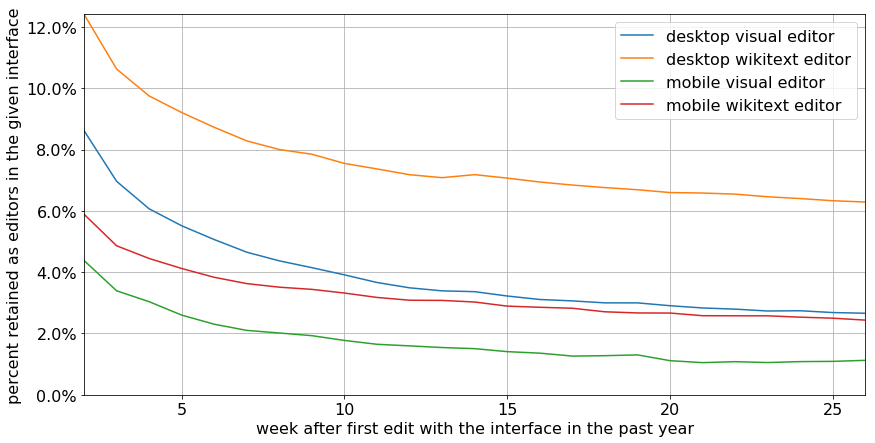

In [268]:
retention_for_graph = weekly_retention.iloc[:, 1:].T
retention_for_graph.index = range(2, 27)
retention_for_graph.plot()
plt.gca().yaxis.set_major_formatter(charting.pct_fmt)
plt.ylim(ymin=0)
plt.ylabel("percent retained as editors in the given interface")
plt.xlabel("week after first edit with the interface in the past year")
plt.legend()

In [237]:
_229.columns

Index(['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7',
       'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13',
       'week 14', 'week 15', 'week 16', 'week 17', 'week 18', 'week 19',
       'week 20', 'week 21', 'week 22', 'week 23', 'week 24', 'week 25',
       'week 26'],
      dtype='object')

In [246]:
second_week = _229["week 2"]
second_week.name = "second week"

In [249]:
second_month_edits = weekly_edits.loc[:, "week 5":"week 8"].sum(axis=1)
second_month = second_month_edits.groupby("interface").agg(pos_prop).map(pct_str)
second_month.name = "second month"

In [251]:
sixth_month_edits = weekly_edits.loc[:, "week 23":"week 26"].sum(axis=1)
sixth_month = sixth_month_edits.groupby("interface").agg(pos_prop).map(pct_str)
sixth_month.name = "sixth month"

In [252]:
pd.concat([second_week, second_month, sixth_month], axis=1)

,second week,second month,sixth month
interface,,,
desktop visual editor,8.6%,11.9%,6.4%
desktop wikitext editor,12.4%,16.7%,11.6%
mobile visual editor,4.4%,6.0%,2.8%
mobile wikitext editor,5.9%,8.7%,5.5%


## By experience

In [230]:
experience = edits_r[["user_name", "interface", "initial_edit_count"]].copy()
experience = experience.groupby(["user_name", "interface"]).first()
experience["initial_experience"] = pd.cut(
    experience["initial_edit_count"], 
    bins=ec_bins[1:], 
    labels=ec_labels[1:],
    right=False
)
experience = experience.drop(["initial_edit_count"], axis=1)
experience.head()

,,initial_experience
user_name,interface,
! Bikkit !,desktop wikitext editor,1-9 edits
!! !!ПОМОГИТЕ СЕСТРЕ НА ОПЕРАЦИЮ!! !!,desktop wikitext editor,1-9 edits
!!7597JOBV++!,desktop wikitext editor,1-9 edits
!!Ethereal!!,desktop wikitext editor,1-9 edits
!!Priyanshu Patel!!,desktop wikitext editor,1-9 edits


In [328]:
retention_by_experience = weekly_edits.join(experience).groupby(
    ["interface", "initial_experience"]
).agg(pos_prop)

retention_by_experience.applymap(pct_str)

week 1 week 2 week 3 week 4  \
interface               initial_experience                                
desktop visual editor   1-9 edits           100.0%   6.9%   5.3%   4.5%   
                        10-99 edits         100.0%  11.1%   9.2%   8.3%   
                        100-999 edits       100.0%  16.8%  15.4%  13.9%   
                        1000+ edits         100.0%  25.0%  23.0%  22.4%   
desktop wikitext editor 1-9 edits           100.0%   9.8%   8.0%   7.1%   
                        10-99 edits         100.0%  16.3%  14.8%  13.8%   
                        100-999 edits       100.0%  22.4%  20.5%  19.7%   
                        1000+ edits         100.0%  35.7%  34.1%  33.2%   
mobile visual editor    1-9 edits           100.0%   2.8%   2.0%   1.9%   
                        10-99 edits         100.0%   9.8%   7.6%   6.5%   
                        100-999 edits       100.0%  15.1%  13.7%  12.9%   
                        1000+ edits         100.0%  16.6%  16.8%  13.6%   
mobile wikitext editor  1-9 edits           100.0%   4.1%   3.2%   2.8%   
                        10-99 edits         100.0%  10.9%   9.4%   8.8%   
                        100-999 edits       100.0%  16.7%  15.1%  15.0%   
                        1000+ edits         100.0%  20.0%  18.4%  17.6%   

                                           week 5 week 6 week 7 week 8 week 9  \
interface               initial_experience                                      
desktop visual editor   1-9 edits            4.0%   3.5%   3.1%   2.9%   2.7%   
                        10-99 edits          7.6%   7.1%   6.5%   6.1%   5.9%   
                        100-999 edits       13.5%  13.1%  12.9%  12.4%  11.7%   
                        1000+ edits         21.7%  21.3%  21.2%  20.0%  20.0%   
desktop wikitext editor 1-9 edits            6.5%   6.1%   5.7%   5.4%   5.2%   
                        10-99 edits         13.3%  12.7%  12.3%  11.9%  11.8%   
                        100-999 edits       19.4%  18.6%  18.1%  17.6%  17.4%   
                        1000+ edits         32.3%  32.1%  31.3%  31.1%  31.1%   
mobile visual editor    1-9 edits            1.5%   1.4%   1.3%   1.1%   1.1%   
                        10-99 edits          6.1%   4.9%   4.7%   5.4%   4.8%   
                        100-999 edits       11.5%  10.4%   9.0%   7.5%   7.2%   
                        1000+ edits         11.6%  11.8%   9.9%   9.9%   9.1%   
mobile wikitext editor  1-9 edits            2.5%   2.3%   2.1%   2.0%   1.9%   
                        10-99 edits          8.5%   7.9%   7.5%   7.5%   7.2%   
                        100-999 edits       14.2%  13.4%  13.3%  12.9%  12.8%   
                        1000+ edits         17.1%  16.5%  16.7%  16.1%  16.3%   

                                           week 10   ...   week 17 week 18  \
interface               initial_experience           ...                     
desktop visual editor   1-9 edits             2.5%   ...      1.6%    1.6%   
                        10-99 edits           5.5%   ...      4.6%    4.5%   
                        100-999 edits        11.6%   ...     10.8%   10.7%   
                        1000+ edits          19.6%   ...     18.8%   18.9%   
desktop wikitext editor 1-9 edits             5.0%   ...      4.2%    4.1%   
                        10-99 edits          11.5%   ...     10.9%   10.8%   
                        100-999 edits        17.0%   ...     16.4%   16.5%   
                        1000+ edits          31.0%   ...     30.2%   29.7%   
mobile visual editor    1-9 edits             1.0%   ...      0.7%    0.7%   
                        10-99 edits           4.2%   ...      3.1%    3.0%   
                        100-999 edits         8.6%   ...      5.9%    6.0%   
                        1000+ edits           8.3%   ...      6.5%    9.1%   
mobile wikitext editor  1-9 edits             1.8%   ...      1.5%    1.4%   
                        10-99 edits           7.1%   ...      5.

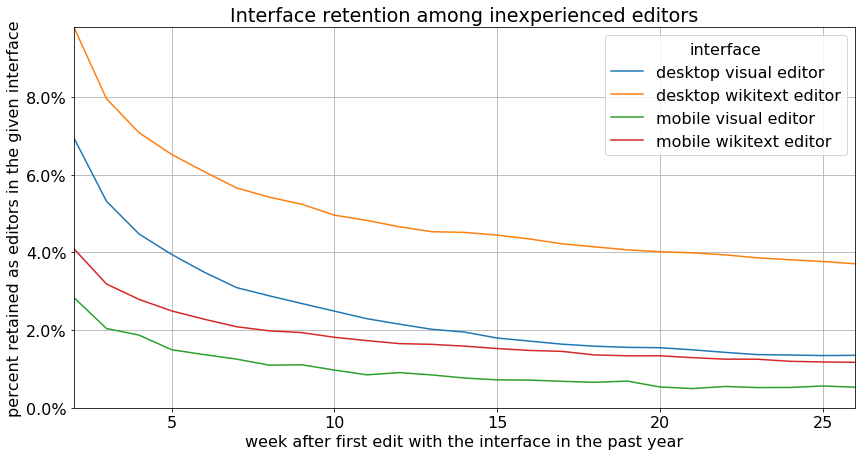

In [330]:
newbie_retention = retention_by_experience.xs("1-9 edits", level=1)

for_graph = newbie_retention.iloc[:, 1:].T
for_graph.index = range(2, 27)

for_graph.plot()
plt.gca().yaxis.set_major_formatter(charting.pct_fmt)
plt.ylim(ymin=0)
plt.ylabel("percent retained as editors in the given interface")
plt.xlabel("week after first edit with the interface in the past year")
plt.title("Interface retention among inexperienced editors");

In [331]:
# How many people are contributing to these statistics?
pd.DataFrame(weekly_edits["week 1"]).join(experience).groupby(["interface", "initial_experience"]).count()

week 1
interface               initial_experience        
desktop visual editor   1-9 edits           256058
                        10-99 edits          55906
                        100-999 edits        19627
                        1000+ edits           7967
desktop wikitext editor 1-9 edits           589884
                        10-99 edits         114853
                        100-999 edits        57749
                        1000+ edits          22566
mobile visual editor    1-9 edits            31681
                        10-99 edits           5255
                        100-999 edits         1361
                        1000+ edits            493
mobile wikitext editor  1-9 edits           194749
                        10-99 edits          24287
                        100-999 edits        11885
                        1000+ edits           6942

# Editor proportion

In [332]:
started = may_sessions.query("ready_count >= 1")
completed = started.query("save_success_count >=1 ")
mobile_edits = completed.query("platform == 'phone'")
desktop_edits = completed.query("platform == 'desktop'")

In [333]:
desktop_edits.groupby("editor")["actions"].agg(lambda grp: len(grp) / len(desktop_edits)).map(pct_str)

editor
visualeditor     9.9%
wikitext        90.1%
Name: actions, dtype: object

In [334]:
mobile_edits.groupby("editor")["actions"].agg(lambda grp: len(grp) / len(mobile_edits)).map(pct_str)

editor
visualeditor     6.1%
wikitext        93.9%
Name: actions, dtype: object

## VE-default wikis

However, on desktop this isn't the fairest of comparisons, since the visual editor isn't available on many wikis and many wikis and many namespaces. How does the picture look when we limit it to VE-default wikis?

To get the list of VE-default wikis, we start with the ["visualeditor-nondefault" database list](https://phabricator.wikimedia.org/source/mediawiki-config/browse/master/dblists/visualeditor-nondefault.dblist?as=source&blame=off). On top of that, we need to add the wikis where visual editor is demoted using settings in [InitialiseSettings.php](https://phabricator.wikimedia.org/source/mediawiki-config/browse/master/wmf-config/InitialiseSettings.php):  wmgVisualEditorSingleEditTabSecondaryEditor (enwiki and frwiktionary) and wmgVisualEditorDisableForAnons (enwiki and eswiki).

In [338]:
# Get raw dblist file
r = requests.get("https://raw.githubusercontent.com/wikimedia/operations-mediawiki-config/master/dblists/visualeditor-nondefault.dblist")

# Strip comments
no_comments = re.sub(r"#.*\n", "", r.text)

# Split by line
nonve_dbs = re.split("\n", no_comments)

# Remove the trailing empty line
nonve_dbs.remove("")

# Add our extras
nonve_dbs.extend(["enwiki", "eswiki", "frwiktionary"])

In [340]:
ve_def_edits = desktop_edits.query('wiki not in @nonve_dbs')

ve_def_edits.groupby("editor")["actions"].agg(lambda grp: len(grp) / len(ve_def_edits)).map(pct_str)

editor
visualeditor    14.8%
wikitext        85.2%
Name: actions, dtype: object

In [341]:
ve_nondef_edits = desktop_edits.query('wiki in @nonve_dbs')
ve_nondef_edits.groupby("editor")["actions"].agg(lambda grp: len(grp) / len(ve_nondef_edits)).map(pct_str)

editor
visualeditor     5.7%
wikitext        94.3%
Name: actions, dtype: object

# Funnel chart

In [342]:
def calc_funnel(df, omitloaded=False, omitsaveintent=False):
    results = OrderedDict()
    
    with_inits = df.query("init_count >= 1") 
    total = len(with_inits)
    results["init"] = len(with_inits) / total
    
    with_readies = with_inits.query("ready_count >= 1")
    results["ready"] = len(with_readies) / total
    
    with_loaded = with_readies.query("loaded_count >= 1")
    if not omitloaded and len(with_loaded) > 0:
        results["loaded"] = len(with_loaded) / total
        with_readies = with_loaded
    
    with_saveintents = with_readies.query("save_intent_count >= 1")
    if not omitsaveintent and len(with_saveintents) > 0:
        results["saveIntent"] = len(with_saveintents) / total
        with_readies = with_saveintents
    
    with_saveattempts = with_readies.query("save_attempt_count >= 1")
    results["saveAttempt"] = len(with_saveattempts) / total
    
    with_savesuccesses = with_saveattempts.query("save_success_count >= 1")
    results["saveSuccess"] = len(with_savesuccesses) / total
    
    return pd.DataFrame(results, index = ["percentage_reaching"]).T.applymap(pct_str)

In [343]:
calc_funnel(may_sessions, omitloaded=True, omitsaveintent=True)

,percentage_reaching
init,100.0%
ready,63.9%
saveAttempt,7.9%
saveSuccess,7.7%


In [345]:
may_sessions.groupby(["platform", "editor"]).apply(calc_funnel).unstack([0, 1]).fillna("—")

percentage_reaching                               
platform                desktop                 phone         
editor             visualeditor wikitext visualeditor wikitext
init                     100.0%   100.0%       100.0%   100.0%
loaded                    92.3%    41.7%            —        —
ready                     92.3%    42.0%        95.4%    97.0%
saveAttempt               12.6%    10.4%        17.1%     2.7%
saveIntent                13.2%        —        18.8%     3.0%
saveSuccess               11.6%    10.2%        15.1%     2.5%

# Edit completion

In [346]:
def completion_rate(df):
    started = df.query("ready_count >= 1")
    completed = started.query("save_success_count >= 1")
    if len(started) > 0:
        return len(completed) / len(started)
    else:
        return None

may_sessions.groupby(["platform"]).apply(completion_rate).map(pct_str)

platform
desktop    22.5%
phone       2.7%
dtype: object

## Desktop

In [347]:
desktop = may_sessions.query("platform == 'desktop'")
desktop.groupby(["editor"]).apply(completion_rate).map(pct_str)

editor
visualeditor    12.6%
wikitext        24.6%
dtype: object

In [348]:
desktop.groupby(["experience", "editor"]).apply(completion_rate).unstack().applymap(pct_str)

editor,visualeditor,wikitext
experience,,
IP,5.2%,6.4%
0 edits (new editor),27.8%,18.0%
1-9 edits,45.3%,35.5%
10-99 edits,57.6%,48.8%
100-999 edits,65.3%,58.4%
1000+ edits,73.3%,71.7%


## Phone

In [349]:
phone = may_sessions.query("platform == 'phone'")
phone.groupby(["editor"]).apply(completion_rate).map(pct_str)

editor
visualeditor    15.8%
wikitext         2.6%
dtype: object

In [350]:
phone.groupby(["experience", "editor"]).apply(completion_rate).unstack().applymap(pct_str)

editor,visualeditor,wikitext
experience,,
IP,11.4%,1.5%
0 edits (new editor),17.4%,21.9%
1-9 edits,28.0%,38.7%
10-99 edits,38.1%,45.8%
100-999 edits,52.1%,55.9%
1000+ edits,58.1%,62.9%


# Time to save

In [351]:
completed["duration"].head()

114   00:07:54
130   00:00:46
137   00:01:55
144   00:28:50
158   00:00:12
Name: duration, dtype: timedelta64[ns]

In [352]:
completed.groupby(["editor", "platform"])["duration"].apply(np.median)

editor        platform
visualeditor  desktop    00:01:40
              phone      00:01:43
wikitext      desktop    00:00:38
              phone      00:00:48
Name: duration, dtype: timedelta64[ns]

In [353]:
def duration_hist(ax, td_ser):
    hist_vals = (
        td_ser
        .astype("timedelta64[s]")
        .replace(0, 1)
    )

    bins = np.floor(
        np.logspace(0, 4, num=40, dtype=int)
    )

    ax.hist(hist_vals, bins=bins, label=None)
    ax.set_xscale("log")

    s_ticks = [1, 10, 60, 10*60, 60*60, 150*60]
    duration_ticks = FixedLocator(s_ticks)
    
    def to_td(s):
        return str(timedelta(seconds=int(s)))
    
    duration_fmt = FuncFormatter(lambda x, pos: to_td(x))
    
    lines = [
        ("10th percentile ({})", hist_vals.quantile(0.1), "xkcd:pink"),
        ("50th percentile ({})", hist_vals.median(), "xkcd:red"),
        ("90th percentile ({})", hist_vals.quantile(0.9), "xkcd:dark red")
        
    ]
    
    for label, pos, color in lines:
        ax.axvline(x=pos, color=color, label=label.format(to_td(pos)))
    
    ax.legend()

    ax.yaxis.set_major_formatter(charting.comma_fmt)
    ax.set_ylabel("number of sampled, completed edit sessions")

    ax.xaxis.set_major_locator(duration_ticks)
    ax.xaxis.set_major_formatter(duration_fmt)
    ax.set_xlabel("session duration as %H:%M:%S (log scale)")
    

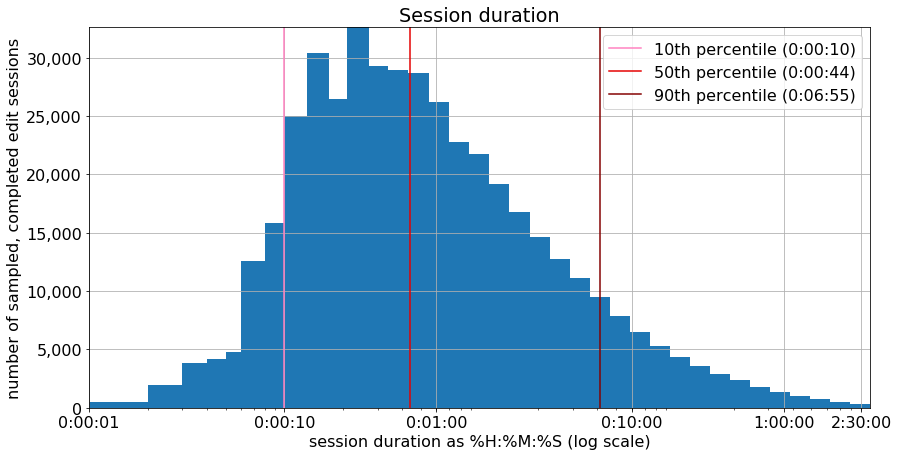

In [354]:
fig, ax = plt.subplots()
ax.set_title("Session duration")
duration_hist(ax, completed["duration"])

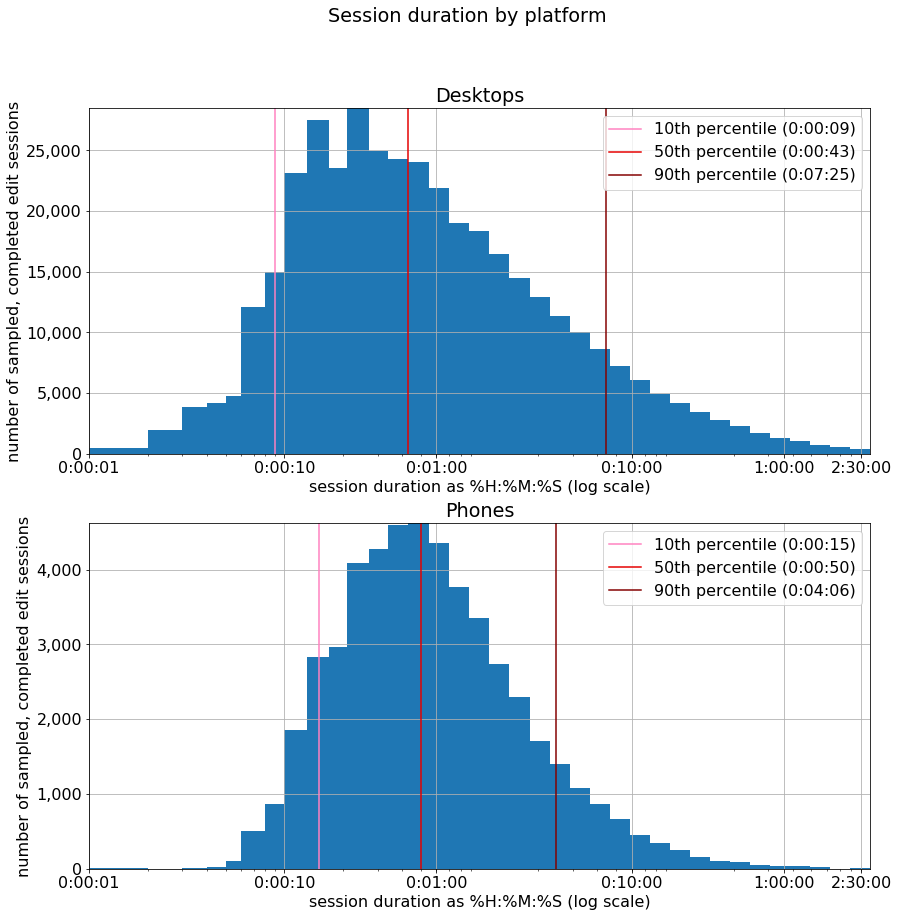

In [355]:
full_desktop = completed.query("platform == 'desktop'")
full_phone = completed.query("platform == 'phone'")

fig, ax = plt.subplots(2, 1, figsize=(14, 14))

fig.suptitle("Session duration by platform")
desktop_ax = ax[0]
phone_ax = ax[1]

duration_hist(desktop_ax, full_desktop["duration"])
desktop_ax.set_title("Desktops")

duration_hist(phone_ax, full_phone["duration"])
phone_ax.set_title("Phones");

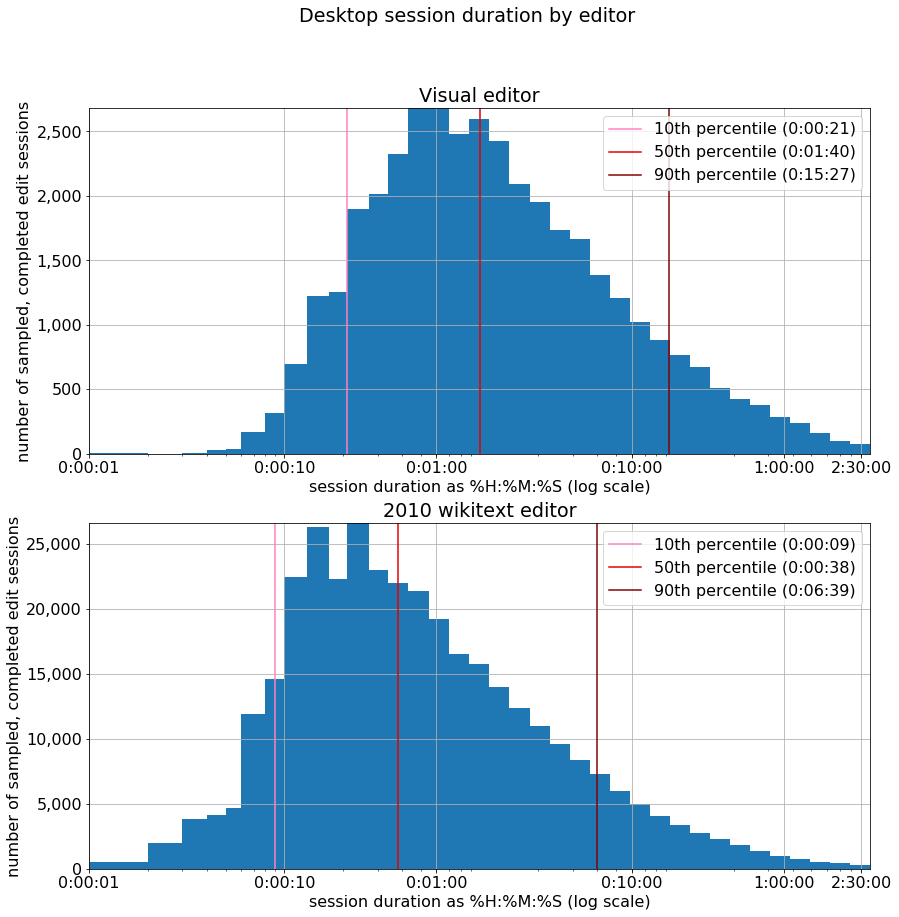

In [356]:
full_desktop_ve = completed.query("platform == 'desktop' & editor == 'visualeditor'")
full_desktop_wte = completed.query("platform == 'desktop' & editor == 'wikitext'")

fig, ax = plt.subplots(2, 1, figsize=(14, 14))

fig.suptitle("Desktop session duration by editor")
ve_ax = ax[0]
wte_ax = ax[1]

duration_hist(ve_ax, full_desktop_ve["duration"])
ve_ax.set_title("Visual editor")

duration_hist(wte_ax, full_desktop_wte["duration"])
wte_ax.set_title("2010 wikitext editor");